# Data Science Workshop

# Data Loading

## Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import sklearn.linear_model as lm
from sklearn import metrics, preprocessing, svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

import random

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

## Reading the Income Classification Dataset

In [85]:
# read the entire file into a python array
with open('raw_data.json', 'rb') as f:
    data = f.readlines()
with open('photos.json', 'rb') as f:
    photos_data = f.readlines()
with open('not_self_feeds.json', 'rb') as f:
    feeds_data = f.readlines()
with open('self_feeds.json', 'rb') as f:
    posts_data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
photos_data = map(lambda x: x.rstrip(), photos_data)
feeds_data = map(lambda x: x.rstrip(), feeds_data)
posts_data = map(lambda x: x.rstrip(), posts_data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"
photos_data_json_str = "[" + ','.join(photos_data) + "]"
feeds_data_json_str = "[" + ','.join(feeds_data) + "]"
posts_data_json_str = "[" + ','.join(posts_data) + "]"

# now, load it into pandas
raw_data = pd.read_json(data_json_str)
photos_raw_data = pd.read_json(photos_data_json_str)
feeds_raw_data = pd.read_json(feeds_data_json_str)
posts_raw_data = pd.read_json(posts_data_json_str)

# join all data frames - used inner join to get rid of outdated pages (pages that got deleted between our queries)
raw_data = pd.merge(left=raw_data, right=photos_raw_data, how='inner', left_on='id', right_on='page_id')
raw_data = pd.merge(left=raw_data, right=posts_raw_data, how='inner', left_on='id', right_on='page_id')
raw_data = pd.merge(left=raw_data, right=feeds_raw_data, how='left', left_on='id', right_on='page_id')

raw_data.drop(['page_id_x', 'page_id_y', 'page_id'], axis=1, inplace=True)

In [86]:
# read the entire file into a python array
# with open('feeds.json', 'rb') as f:
#     data = f.readlines()
# data = map(lambda x: x.rstrip(), data)
# data_json_str = "[" + ','.join(data) + "]"
# raw_data = pd.read_json(data_json_str)


# Data preparation

In [87]:
# currentLocation and current_location are too sparse and it's not clear if its a city/country etc..
ready_feats = [ 'has_cover_photo', 'has_profile_photo', 'id', 'likes', 

                # photo fields
                'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 'photo_avg_likes_per_photo',
                'photo_avg_people_tagged_per_photo', 'photo_avg_people_tagged_per_photo_with_more_than_zero', 
                'photo_count_has_name', 'photo_count_has_place', 'photo_distinct_uploaders', 
                'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 'photo_number_of_albums', 
                'photo_number_of_cover_albums', 'photo_number_of_different_months_for_photos', 'photo_number_of_null_albums', 
                'photo_number_of_other_albums', 'photo_number_of_photos_in_cover_albums', 'photo_number_of_photos_in_null_albums', 
                'photo_number_of_photos_in_other_albums', 'photo_number_of_photos_in_profile_albums', 
                'photo_number_of_profile_albums', 'total_photos', 'photo_number_of_days_between_first_and_last_photos',
               
                # feed fields
                'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
                'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_number_of_days_between_first_and_last_posts',
                'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_count_has_place', 
                'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
                'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
                'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
                'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                'feed_post_updated_prc', 'feed_std_comments', 'feed_std_likes', 'feed_sum_people_tagged_count', 
                'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares', 'feed_std_shares',
                'feed_distinct_post_writers', 'feed_post_count',

                # posts fields
                'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_likes_per_comment',                           
                'self_feed_avg_people_tagged_per_post', 'self_feed_avg_people_tagged_per_post_with_more_than_zero',  
                'self_feed_number_of_days_between_first_and_last_posts', 'self_feed_avg_with_tagged_per_post',                        
                'self_feed_avg_with_tagged_per_post_with_more_than_zero', 'self_feed_count_has_place',                                 
                'self_feed_count_post_updated', 'self_feed_is_published_count', 'self_feed_max_comments',
                'self_feed_max_likes', 'self_feed_min_comments', 'self_feed_min_likes', 'self_feed_number_of_added_photos_category',                 
                'self_feed_number_of_different_months_for_post', 'self_feed_number_of_null_category', 'self_feed_number_of_other_categories',                      
                'self_feed_number_of_shared_story_category', 'self_feed_post_max_people_tagged', 'self_feed_post_max_with_tagged',                            
                'self_feed_post_updated_prc', 'self_feed_std_comments', 'self_feed_std_likes', 'self_feed_sum_people_tagged_count',                         
                'self_feed_sum_with_tagged_count', 'self_feed_avg_shares', 'self_feed_max_shares', 'self_feed_min_shares',                                      
                'self_feed_std_shares', 'self_post_count'
              ]

all_data = raw_data[ready_feats].copy()

# merge identical columns
all_data['general_info'] = pd.concat([raw_data['generalInfo'].dropna(), raw_data['general_info'].dropna()]).reindex_like(raw_data)
all_data['is_permanently_closed'] = pd.concat([raw_data['isPermanentlyClosed'].dropna(), raw_data['is_permanently_closed'].dropna()]).reindex_like(raw_data)
all_data['is_unclaimed'] = pd.concat([raw_data['isUnclaimed'].dropna(), raw_data['is_unclaimed'].dropna()]).reindex_like(raw_data)
all_data['is_verified'] = pd.concat([raw_data['isVerified'].dropna(), raw_data['is_verified'].dropna()]).reindex_like(raw_data)
all_data['price_range'] = pd.concat([raw_data['priceRange'].dropna(), raw_data['price_range'].dropna()]).reindex_like(raw_data)
all_data['start_info'] = pd.concat([raw_data['startInfo'].dropna(), raw_data['start_info'].dropna()]).reindex_like(raw_data)
all_data['talking_about_count'] = pd.concat([raw_data['talkingAboutCount'].dropna(), raw_data['talking_about_count'].dropna()]).reindex_like(raw_data)
all_data['were_here_count'] = pd.concat([raw_data['wereHereCount'].dropna(), raw_data['were_here_count'].dropna()]).reindex_like(raw_data)

# create 'has' columns
all_data['has_email'] = raw_data['emails'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_phone'] = raw_data['phone'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_website'] = raw_data['website'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_location'] = raw_data['location'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_description'] = raw_data['description'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_general_info'] = all_data['general_info'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_products'] = raw_data['products'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)

# create 'num of words' columns
all_data['name_num_of_words'] = raw_data['name'].apply(lambda x: len(x.split()) if type(x) != np.float else np.nan)

# parse complex vars
all_data['location_city'] = raw_data['location'].apply(lambda x: x['city'] if (type(x) != np.float and 'city' in x) else np.nan)
all_data['location_city'].fillna(raw_data['hometown'], inplace=True)
all_data['location_country'] = raw_data['location'].apply(lambda x: x['country'] if (type(x) != np.float and 'country' in x) else np.nan)
all_data['start_info'] = all_data['start_info'].apply(lambda x: x['date']['year'] if (type(x) != np.float and 'date' in x and 'year' in x['date']) else np.nan)
all_data['price_range'] = all_data['price_range'].apply(lambda x: len(x) if type(x) != np.float else np.nan)

# frequency related features - move to feature eng
all_data['photo_upload_freq'] = all_data.apply(lambda x: x['photo_number_of_days_between_first_and_last_photos']/x['total_photos'] if x['photo_number_of_days_between_first_and_last_photos'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
all_data['feed_update_freq'] = all_data.apply(lambda x: x['feed_number_of_days_between_first_and_last_posts']/x['feed_post_count'] if x['feed_number_of_days_between_first_and_last_posts'] != np.nan and x['feed_post_count'] != np.nan else 0, axis=1)
all_data['posting_freq'] = all_data.apply(lambda x: x['self_feed_number_of_days_between_first_and_last_posts']/x['self_post_count'] if x['self_feed_number_of_days_between_first_and_last_posts'] != np.nan and x['self_post_count'] != np.nan else 0, axis=1)

# convert types
all_data['founded'] = raw_data['founded'].apply(lambda x: np.int64(x) if (type(x) == unicode and x.strip().isdigit()) else np.nan)

# drop duplicate pages (we got some pages twice because we queried by page category and some pages were in several categrories)
all_data.drop_duplicates(subset='id', keep='last', inplace=True)

## Missing Data Imputation

In [88]:
print "Missing data by column (total rows %s):" % all_data.id.count()
missing_count = all_data.isnull().sum()
print missing_count[missing_count.nonzero()[0]]

Missing data by column (total rows 12773):
photo_avg_people_tagged_per_photo_with_more_than_zero        7572
feed_avg_comments                                            7501
feed_avg_likes                                               7501
feed_avg_likes_per_comment                                   7323
feed_avg_people_tagged_per_post                              8470
feed_avg_people_tagged_per_post_with_more_than_zero         12031
feed_number_of_days_between_first_and_last_posts             8470
feed_avg_with_tagged_per_post                                8470
feed_avg_with_tagged_per_post_with_more_than_zero           12505
feed_count_has_place                                         7323
feed_count_post_updated                                      7323
feed_is_published_count                                      7323
feed_max_comments                                            7501
feed_max_likes                                               7501
feed_min_comments                

In [89]:
# drop features too sparse or that have no meaningful way to fill
feats_to_drop = ['founded', 'start_info', 'general_info']
all_data.drop(feats_to_drop, axis = 1, inplace=True)

# NaN to 0
numeric_impute = [  'photo_avg_people_tagged_per_photo_with_more_than_zero', 'price_range',
                  
                    'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
                    'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_number_of_days_between_first_and_last_posts',
                    'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_count_has_place', 
                    'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
                    'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
                    'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
                    'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                    'feed_post_updated_prc', 'feed_std_comments', 'feed_std_likes', 'feed_sum_people_tagged_count', 
                    'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares', 'feed_std_shares',
                    'feed_distinct_post_writers', 'feed_post_count', 'feed_update_freq',
                    
                    'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_people_tagged_per_post', 
                    'self_feed_avg_people_tagged_per_post_with_more_than_zero', 'self_feed_number_of_days_between_first_and_last_posts', 
                    'self_feed_avg_with_tagged_per_post', 'self_feed_avg_with_tagged_per_post_with_more_than_zero', 'self_feed_max_comments', 
                    'self_feed_max_likes', 'self_feed_min_comments', 'self_feed_min_likes', 'self_feed_post_max_people_tagged', 
                    'self_feed_post_max_with_tagged', 'self_feed_std_comments', 'self_feed_std_likes', 'self_feed_sum_people_tagged_count', 
                    'self_feed_sum_with_tagged_count', 'self_feed_avg_shares', 'self_feed_max_shares', 'self_feed_min_shares', 
                    'self_feed_std_shares', 'posting_freq',
                 ]
all_data[numeric_impute] = all_data[numeric_impute].fillna(0) 

# fill missing countries by city
all_data['location_country'].fillna('empty', inplace=True)
all_data['location_city'].fillna('empty', inplace=True)
temp = {k: g["location_country"].tolist() for k,g in all_data.groupby("location_city")}
city_to_country = {}
for city, countries in temp.items():
    if city == 'empty':
        city_to_country[city] = 'empty'
        continue
    for country in countries:
        if country != 'empty':
            city_to_country[city] = country
            break
    if city_to_country.get(city) is None:
        city_to_country[city] = 'empty'
all_data['location_country'] = all_data.apply(lambda x: x['location_country'] if x['location_country'] != 'empty' else city_to_country[x['location_city']], axis=1)
all_data['location_country'].fillna('empty', inplace=True)
val_count = all_data['location_country'].value_counts()
all_data['country'] = all_data.location_country.apply(lambda x: x if val_count[x] > 150 else 'other')
all_data.drop(['location_city', 'location_country'], axis = 1, inplace=True)

print "Columns with missing data: ", all_data.isnull().sum().nonzero()[0]

Columns with missing data:  []


## Types Conversion

In [90]:
binary_variables = ['has_email', 'has_phone', 'has_website', 'has_location', 'is_permanently_closed', 'is_unclaimed', 'is_verified', 'has_description', 'has_general_info', 'has_products']
categorical_variables = ['country', 'price_range']

for variable in binary_variables:
    all_data[variable] = all_data[variable].astype(int)
    
for feat in all_data.columns.get_values():
    print "%s\t%s\t%s" % (all_data.columns.get_loc(feat), all_data.dtypes[all_data.columns.get_loc(feat)], feat)

0	int64	has_cover_photo
1	int64	has_profile_photo
2	int64	id
3	int64	likes
4	float64	photo_avg_comments_per_photo
5	float64	photo_avg_likes_per_comments
6	float64	photo_avg_likes_per_photo
7	float64	photo_avg_people_tagged_per_photo
8	float64	photo_avg_people_tagged_per_photo_with_more_than_zero
9	int64	photo_count_has_name
10	int64	photo_count_has_place
11	int64	photo_distinct_uploaders
12	int64	photo_max_like
13	int64	photo_max_people_tagged
14	int64	photo_min_like
15	int64	photo_number_of_albums
16	int64	photo_number_of_cover_albums
17	int64	photo_number_of_different_months_for_photos
18	int64	photo_number_of_null_albums
19	int64	photo_number_of_other_albums
20	int64	photo_number_of_photos_in_cover_albums
21	int64	photo_number_of_photos_in_null_albums
22	int64	photo_number_of_photos_in_other_albums
23	int64	photo_number_of_photos_in_profile_albums
24	int64	photo_number_of_profile_albums
25	int64	total_photos
26	int64	photo_number_of_days_between_first_and_last_photos
27	float64	feed

# Data Exploration

In [56]:
for feat in all_data.columns.get_values():
    if feat != 'id':
        print "==============================================="
        print all_data[feat].describe()

count   12,824.00
mean         0.18
std          0.39
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_cover_photo, dtype: float64
count   12,824.00
mean         1.00
std          0.00
min          1.00
25%          1.00
50%          1.00
75%          1.00
max          1.00
Name: has_profile_photo, dtype: float64
count        12,824.00
mean        431,188.25
std       2,216,919.61
min               0.00
25%           9,165.50
50%          38,001.50
75%         172,098.00
max     102,762,509.00
Name: likes, dtype: float64
count   12,824.00
mean        36.59
std        221.48
min          1.00
25%          2.36
50%          5.39
75%         17.95
max     15,959.76
Name: photo_avg_comments_per_photo, dtype: float64
count   12,824.00
mean        14.09
std         92.08
min          0.00
25%          0.88
50%          2.30
75%          6.20
max      5,302.80
Name: photo_avg_likes_per_comments, dtype: float64
count    12,824.00
mean        9

In [ ]:
has_columns = [a for a in all_data.columns.get_values() if 'has' in a]

### Likes analysis

count        12,824.00
mean        431,188.25
std       2,216,919.61
min               0.00
25%           9,165.50
50%          38,001.50
75%         172,098.00
max     102,762,509.00
Name: likes, dtype: float64


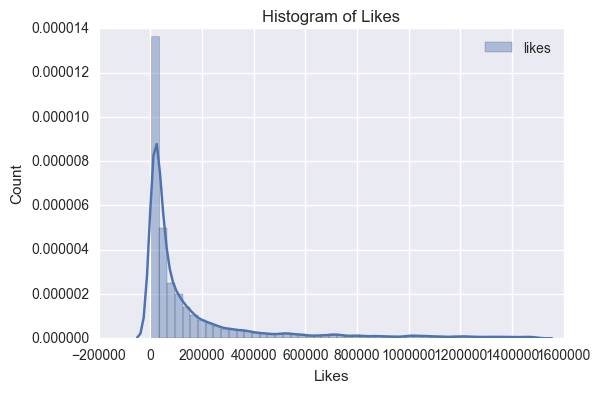

count   12,824.00
mean        10.59
std          2.27
min          0.00
25%          9.12
50%         10.55
75%         12.06
max         18.45
Name: likes, dtype: float64


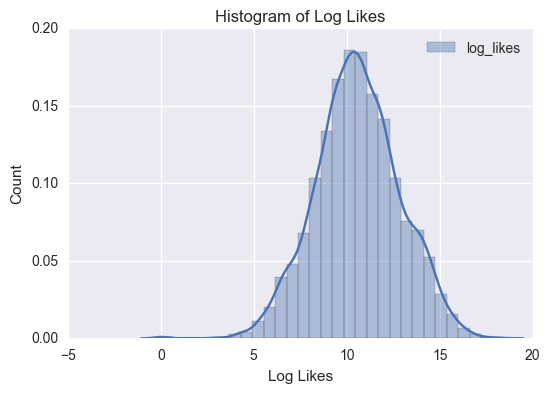

In [101]:
print all_data.likes.describe()
sns.distplot(all_data[(all_data['likes'] > 5000) & (all_data['likes'] < 1500000)].likes, 
             bins = 50, kde = True, label = "likes")
plt.title('Histogram of Likes')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

log_likes = all_data['likes'].apply(lambda x: np.log(x) if x > 0 else 0)
print log_likes.describe()
sns.distplot(log_likes, bins = 30, kde = True, label = "log_likes")
plt.title('Histogram of Log Likes')
plt.xlabel('Log Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()


In [80]:
# print all_data.fanCount.describe()
# sns.distplot(all_data[(all_data['fanCount'] > 100) & (all_data['fanCount'] < 50000)].fanCount, 
#              bins = 50, kde = True, label = "fanCount")
# plt.title('Histogram of fanCount')
# plt.xlabel('fanCount')
# plt.ylabel('Count')
# plt.legend(loc="upper right")
# plt.show()

In [161]:
def show_numric_features(features):
    for key in features.keys():
        key_dict = features.get(key)
        col = key_dict.get('column')
        data_to_show = all_data[(all_data[col] >= key_dict.get('lower_bound')) & 
                              (all_data[col] <= key_dict.get('upper_bound'))][col]
        print data_to_show.describe()

        sns.distplot(data_to_show, 
                     bins = key_dict.get('bins'), kde = key_dict.get('kde'), label = key)
        plt.title('Histogram of ' + key)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(loc="upper right")
        plt.show()
        
def show_categorical_features(features):
   for feat in features:
        data_to_show = all_data[[feat]]
        unique_values = data_to_show[feat].unique().tolist()
        unique_values.sort()
        if (unique_values == [0,1]):
            data_to_show = data_to_show.astype(bool)
        sns.plt.title(feat + ' count')
        ax = sns.countplot(feat, data=data_to_show) #,color='purple')
        sns.plt.show()

def show_categorical_data(data):
    for df in data:
        feat = df.columns.tolist()[0]
        ax = sns.countplot(feat, data=df)
        sns.plt.show()

### Page features

count    3,967.00
mean    14,439.31
std     16,838.60
min      2,003.00
25%      3,612.00
50%      7,125.00
75%     17,710.50
max     79,926.00
Name: talking_about_count, dtype: float64


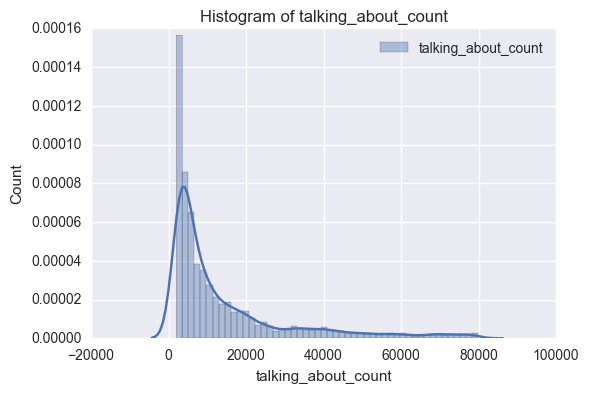

count    5,611.00
mean     1,501.11
std      2,850.55
min         10.00
25%         67.00
50%        265.00
75%      1,285.50
max     14,908.00
Name: were_here_count, dtype: float64


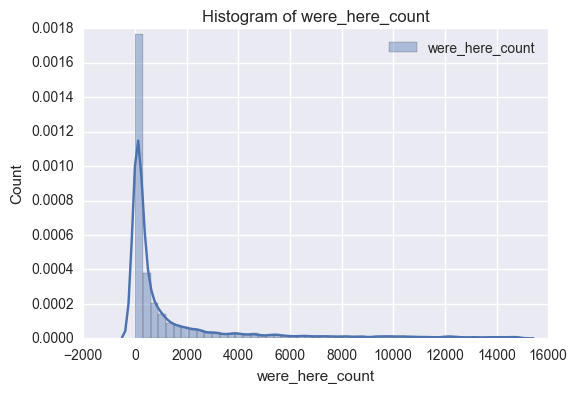

In [162]:
page_numric_features = {'talking_about_count':{'column': 'talking_about_count','lower_bound': 2000, 'upper_bound': 80000, 'bins': 50, 'kde': True},
        'were_here_count':{'column': 'were_here_count','lower_bound': 10, 'upper_bound': 15000, 'bins': 50, 'kde': True}
        }
show_numric_features(page_numric_features)


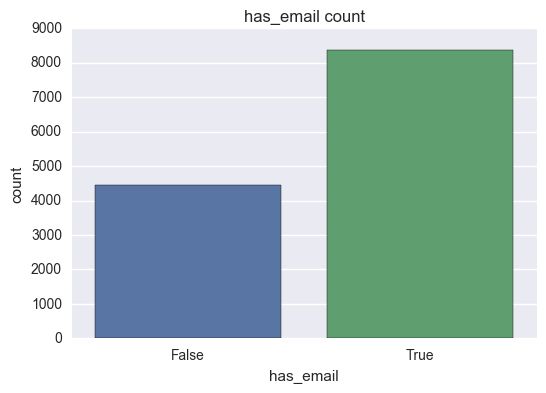

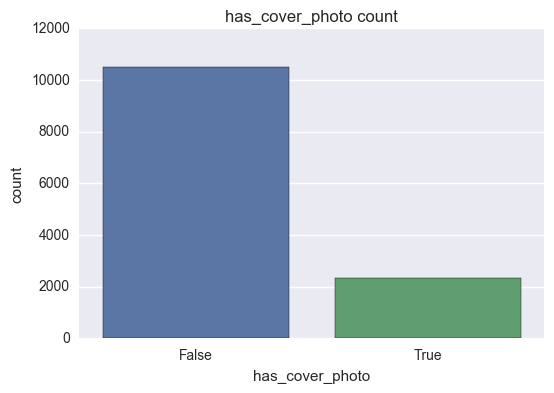

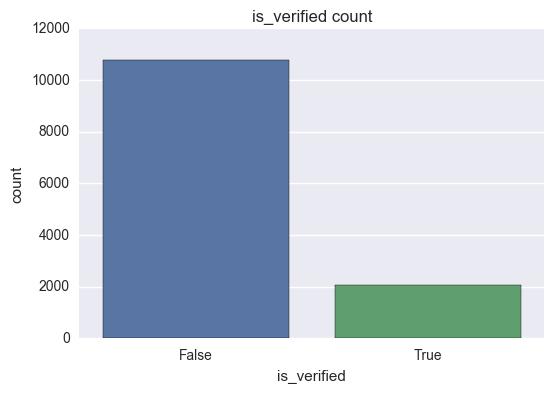

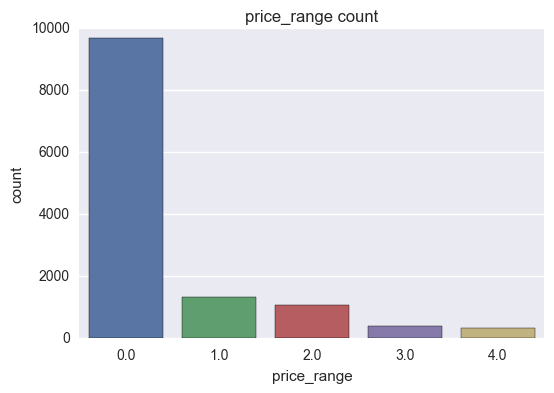

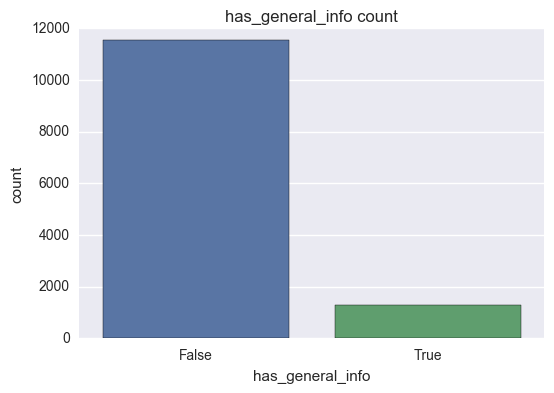

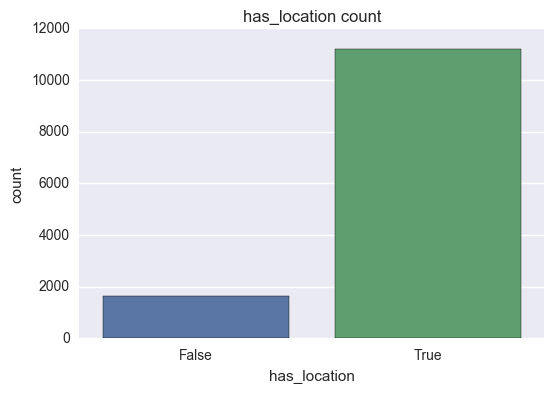

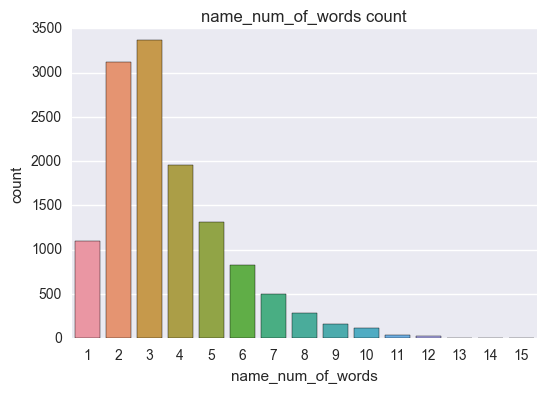

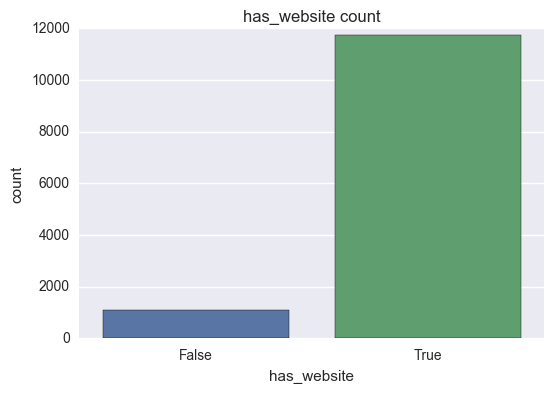

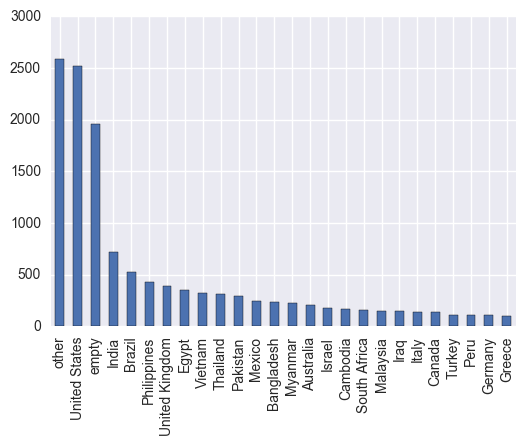

In [163]:
page_categorical_features = ['has_email', 'has_cover_photo', 'is_verified', 'price_range', 
                             'has_general_info', 'has_location', 'name_num_of_words', 'has_website']

show_categorical_features(page_categorical_features)

# countries count plot
countries = all_data['country'].value_counts().plot(kind='bar')
plt.show()


In [18]:
# sns.distplot(all_data[(all_data['description_len'] > 0) & (all_data['description_len'] < 3000)].description_len, 
#              bins = 25, kde = True, label = "description_len")
# plt.title('Histogram of description_length')
# plt.xlabel('description_length')
# plt.ylabel('Count')
# plt.legend(loc="upper right")
# plt.show()

In [19]:
# sns.distplot(all_data[(all_data['general_info_len'] > 0) & (all_data['general_info_len'] < 3000)].general_info_len, 
#              bins = 25, kde = True, label = "general_info_len")
# plt.title('Histogram of general_info_len')
# plt.xlabel('general_info_len')
# plt.ylabel('Count')
# plt.legend(loc="upper right")
# plt.show()

In [20]:
# sns.distplot(all_data[(all_data['products_len'] > 0) & (all_data['products_len'] < 1500)].products_len, 
#              bins = 25, kde = True, label = "products_len")
# plt.title('Histogram of products_len')
# plt.xlabel('products_len')
# plt.ylabel('Count')
# plt.legend(loc="upper right")
# plt.show()

In [94]:
# named_labels = all_data.is_verified.map({0:'unverified', 1:'verified'})
# named_labels.value_counts().plot(kind='bar')

In [95]:
# named_labels = all_data.has_website.map({0:'has_website', 1:'doesnt_have_website'})
# named_labels.value_counts().plot(kind='bar')

In [99]:
# x = all_data['country'].value_counts().plot(kind='bar')
# plt.show()

### Feed features

count   9,785.00
mean       59.42
std        82.53
min         5.00
25%        12.00
50%        25.00
75%        69.00
max       499.00
Name: feed_number_of_days_between_first_and_last_posts, dtype: float64


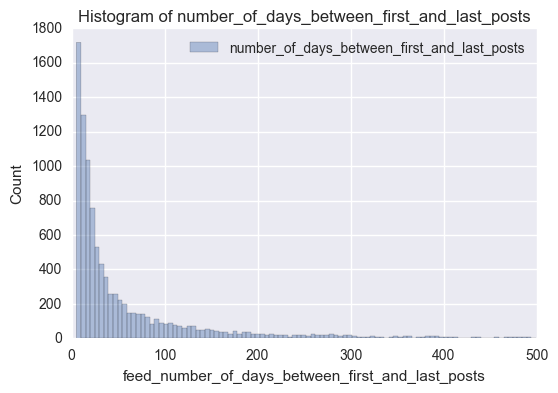

count   7,576.00
mean      424.72
std       556.43
min        30.00
25%        74.44
50%       185.68
75%       522.91
max     2,998.59
Name: feed_avg_likes, dtype: float64


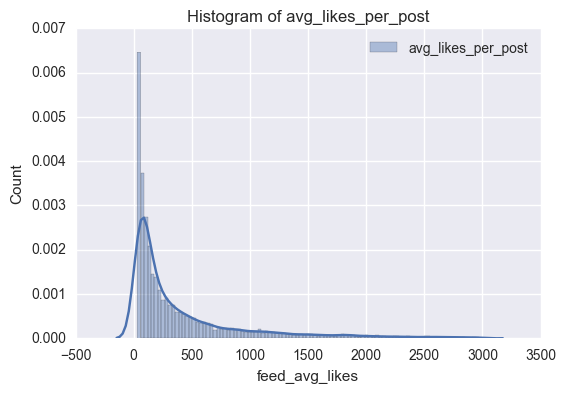

count   4,050.00
mean       71.15
std       121.71
min        10.00
25%        16.53
50%        28.91
75%        66.53
max       989.33
Name: feed_avg_comments, dtype: float64


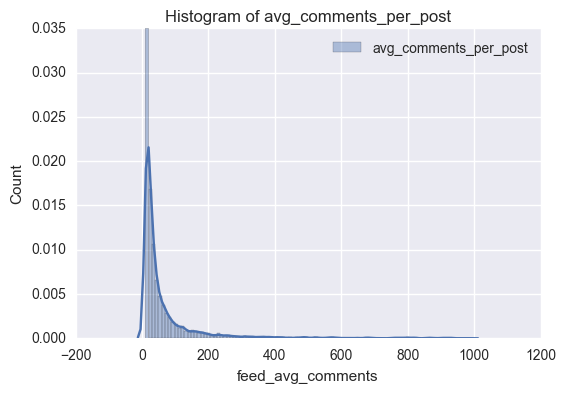

count   8,771.00
mean       48.23
std        70.39
min         4.00
25%         8.48
50%        18.76
75%        52.23
max       398.38
Name: feed_avg_shares, dtype: float64


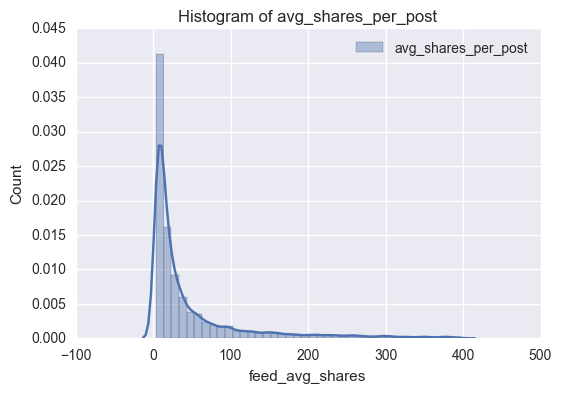

count   434.00
mean     12.59
std      11.30
min       5.00
25%       6.25
50%       9.00
75%      13.97
max      97.00
Name: feed_avg_with_tagged_per_post_with_more_than_zero, dtype: float64


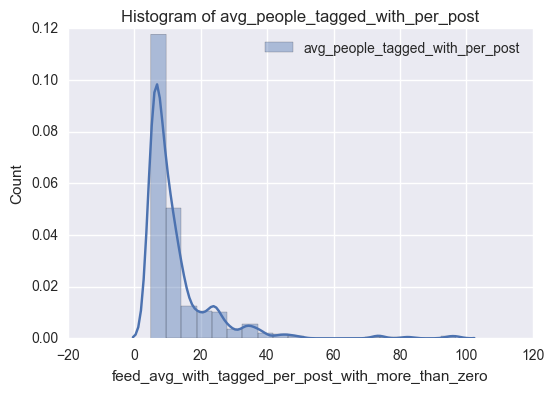

count   2,440.00
mean       72.26
std        44.48
min         1.00
25%        33.00
50%        68.00
75%       111.00
max       149.00
Name: post_count, dtype: float64


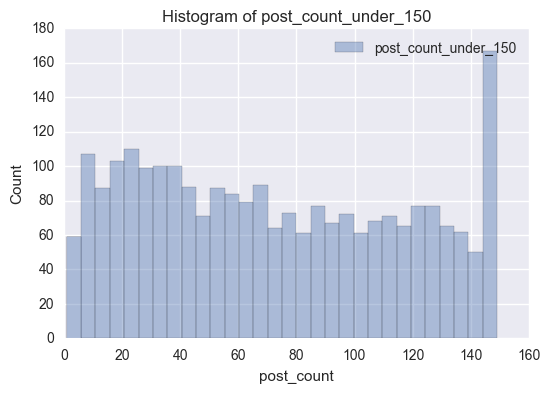

count   98.00
mean     8.32
std      5.34
min      5.00
25%      5.58
50%      7.00
75%      9.19
max     48.09
Name: feed_avg_people_tagged_per_post_with_more_than_zero, dtype: float64


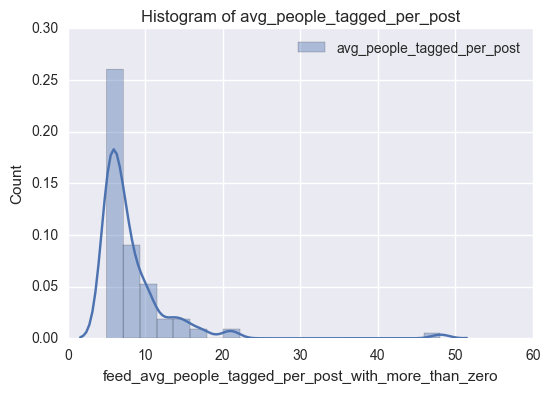

In [105]:
feed_numric_features = {'post_count_under_150':{'column': 'post_count','lower_bound': 0, 'upper_bound': 149, 'bins': 30, 'kde': False},
                        'avg_likes_per_post':{'column': 'feed_avg_likes','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_comments_per_post': {'column': 'feed_avg_comments','lower_bound': 10, 'upper_bound': 1000, 'bins': 100, 'kde': True},
                        'avg_shares_per_post': {'column': 'feed_avg_shares','lower_bound': 4, 'upper_bound': 400, 'bins': 40, 'kde': True},

                        #'max_comments_per_post': {'column': 'feed_max_comments','lower_bound': 50, 'upper_bound': 5000, 'bins': 100, 'kde': True},
                        'avg_people_tagged_per_post':{'column': 'feed_avg_people_tagged_per_post_with_more_than_zero','lower_bound': 5, 'upper_bound': 100, 'bins': 20, 'kde': True},
                        'avg_people_tagged_with_per_post':{'column': 'feed_avg_with_tagged_per_post_with_more_than_zero','lower_bound': 5, 'upper_bound': 100, 'bins': 20, 'kde': True},
                        'number_of_days_between_first_and_last_posts': {'column': 'feed_number_of_days_between_first_and_last_posts','lower_bound': 5, 'upper_bound': 500, 'bins': 100, 'kde': False}}

show_numric_features(feed_numric_features)


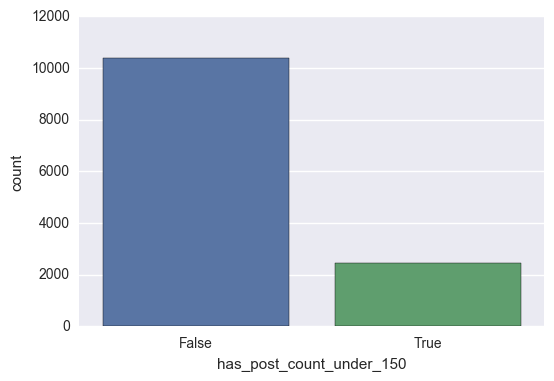

In [164]:
data = [all_data['post_count'].apply(lambda x: True if x < 150 else False).to_frame('has_post_count_under_150')]
show_categorical_data(data)

### Photos features

count   12,805.00
mean         3.21
std          1.93
min          1.00
25%          2.00
50%          3.00
75%          4.00
max         20.00
Name: photo_number_of_albums, dtype: float64


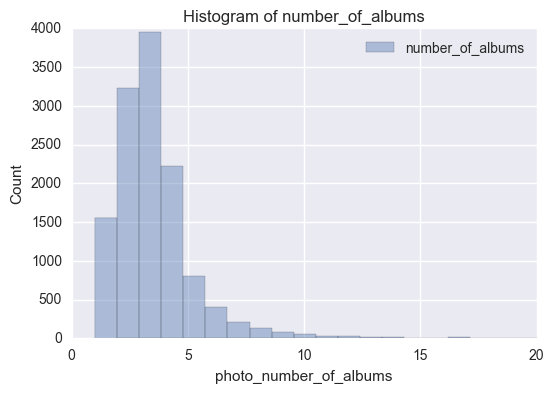

count   8,838.00
mean        5.04
std         6.47
min         1.00
25%         1.00
50%         2.00
75%         6.00
max        40.00
Name: photo_number_of_photos_in_profile_albums, dtype: float64


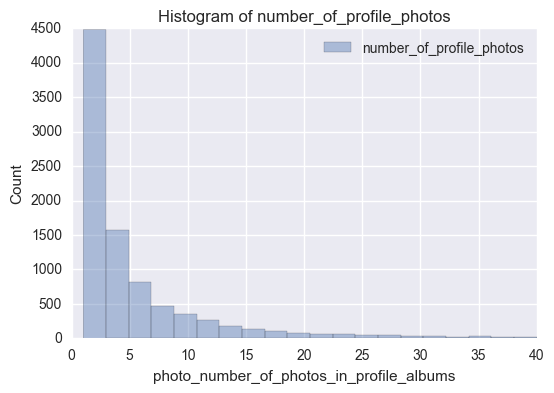

count   2,230.00
mean      153.27
std       232.33
min        30.00
25%        44.23
50%        73.65
75%       154.27
max     2,714.94
Name: photo_avg_comments_per_photo, dtype: float64


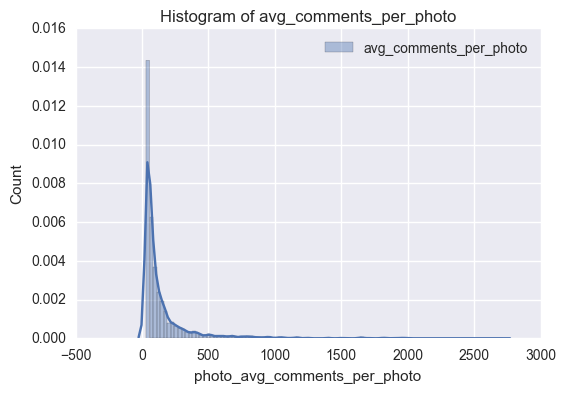

count   1,804.00
mean        6.92
std         4.82
min         3.00
25%         3.75
50%         5.00
75%         8.23
max        25.00
Name: photo_avg_people_tagged_per_photo_with_more_than_zero, dtype: float64


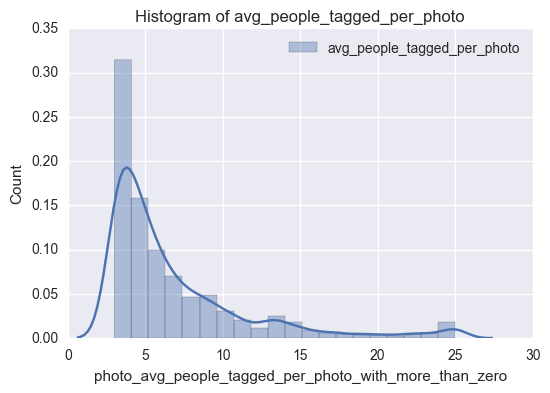

count   8,172.00
mean      441.58
std       579.62
min        30.00
25%        75.82
50%       193.40
75%       544.39
max     2,998.54
Name: photo_avg_likes_per_photo, dtype: float64


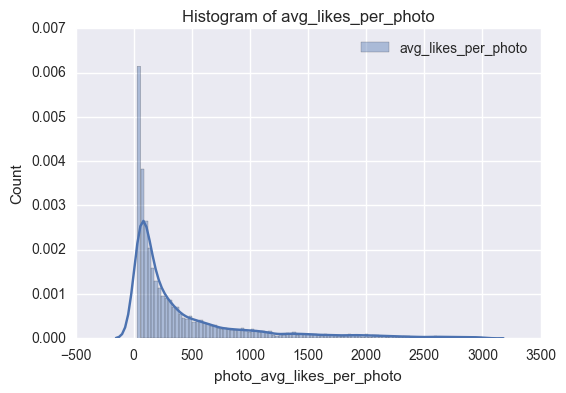

In [156]:
photo_numric_features = {'avg_likes_per_photo':{'column': 'photo_avg_likes_per_photo','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_comments_per_photo':{'column': 'photo_avg_comments_per_photo','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_people_tagged_per_photo':{'column': 'photo_avg_people_tagged_per_photo_with_more_than_zero','lower_bound': 3, 'upper_bound': 100, 'bins': 20, 'kde': True},
                        'number_of_albums': {'column': 'photo_number_of_albums','lower_bound': 0, 'upper_bound': 20, 'bins': 20, 'kde': False},
                        'number_of_profile_photos': {'column':'photo_number_of_photos_in_profile_albums', 'lower_bound': 1, 'upper_bound': 40, 'bins': 20, 'kde': False}}

show_numric_features(photo_numric_features)

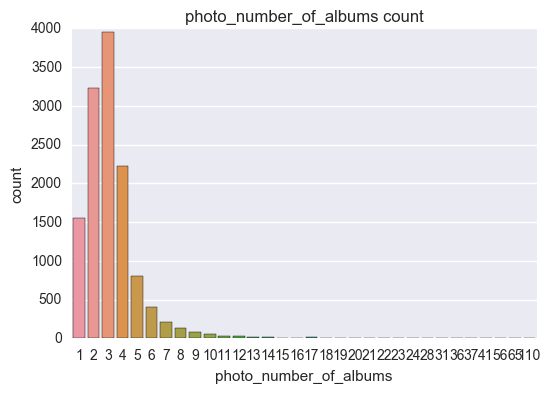

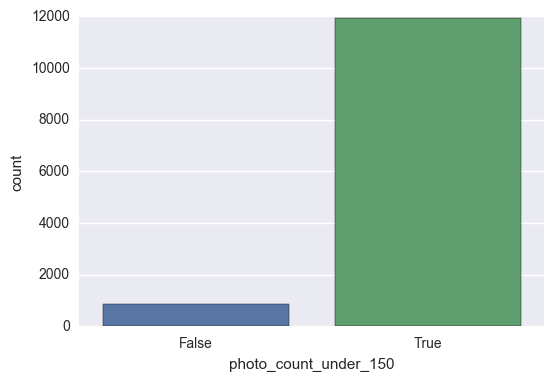

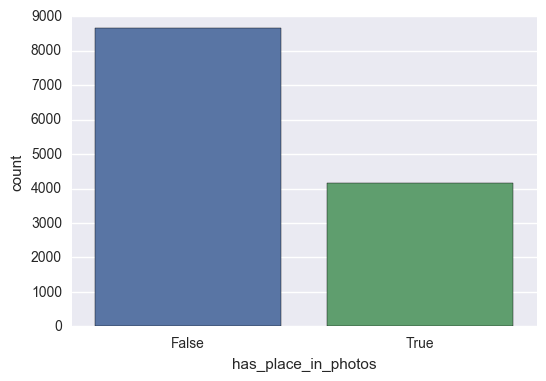

In [165]:
page_categorical_features = ['photo_number_of_albums'] #TODO: add upper bound / move to numrical

show_categorical_features(page_categorical_features)

feat = 'photo_count_under_150'
data = [all_data['total_photos'].apply(lambda x: True if x < 150 else False).to_frame('photo_count_under_150'),
       all_data['photo_count_has_place'].apply(lambda x: True if x > 0 else False).to_frame('has_place_in_photos')]

show_categorical_data(data)
# show_categorical_data(feat, data_to_show)

### Outliers

In [88]:
 all_data[all_data['is_permanently_closed'] == 1].shape[0]

5

In [91]:
 all_data[all_data['likes'] > 1500000].shape[0]

760

In [114]:
all_data[all_data['photo_distinct_uploaders'] > 1].shape[0]

0

In [115]:
all_data[all_data['has_profile_photo'] < 1].shape[0]

0

## Correlations

In [169]:
# detail_variables = ['description_len', 'general_info_len', 'products_len']
# all_data[detail_variables].corr()

In [192]:
def show_correlation(columns):
    data = all_data[columns]
#     data.corr()  
    pd.tools.plotting.scatter_matrix(data, alpha = 0.2, figsize = (8,8), diagonal = 'kde')
    plt.show()

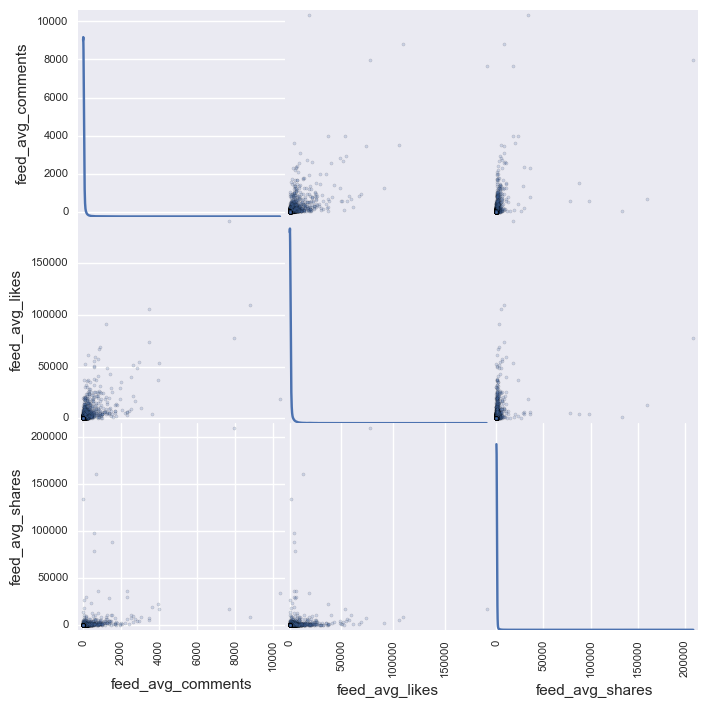

,feed_avg_comments,feed_avg_likes,feed_avg_shares
feed_avg_comments,1.00,0.66,0.41
feed_avg_likes,0.66,1.00,0.23
feed_avg_shares,0.41,0.23,1.00


In [203]:
interaction_variables = ['likes', 'talking_about_count', 'were_here_count'] #'fanCount', 
photo_tags =['photo_avg_people_tagged_per_photo', 'photo_avg_people_tagged_per_photo_with_more_than_zero']
feed_tags = ['feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 
             'feed_avg_people_tagged_per_post', 'feed_avg_people_tagged_per_post_with_more_than_zero']
photo_likes = ['photo_max_like', 'photo_min_like', 'photo_avg_likes_per_photo']
feed_interactions = ['feed_avg_comments', 'feed_avg_likes', 'feed_avg_shares']
feed_categories = ['feed_number_of_added_photos_category','feed_number_of_different_months_for_post',
                   'feed_number_of_null_category', u'feed_number_of_other_categories','feed_number_of_shared_story_category']



show_correlation(feed_interactions)
all_data[feed_interactions].corr()
# show_correlation(photo_likes)
# all_data[feed_tags].corr()

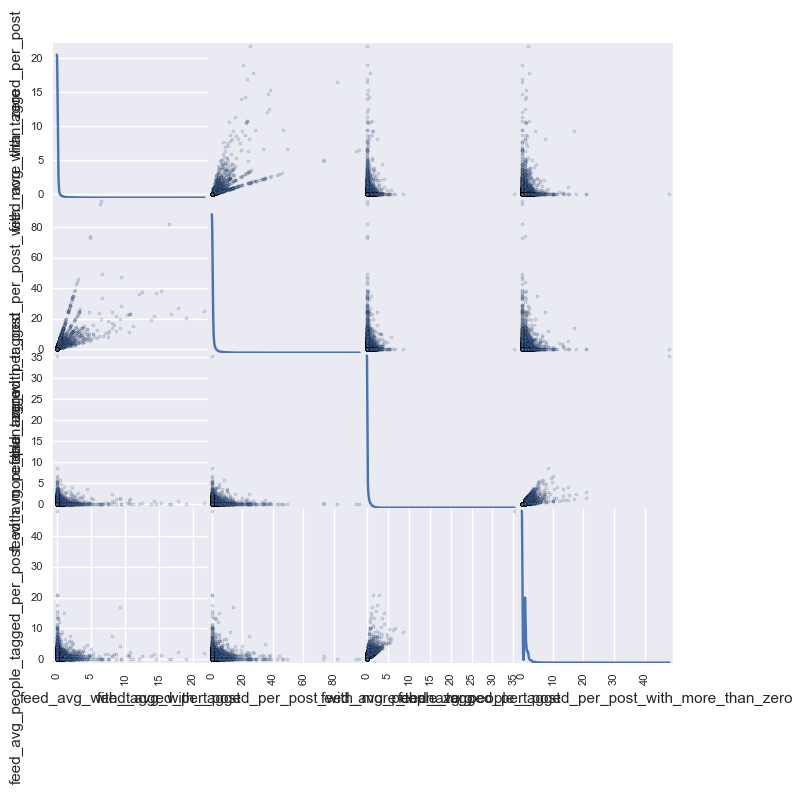

In [191]:
text = all_data[feed_tags]
pd.tools.plotting.scatter_matrix(text, alpha = 0.2, figsize = (8,8), diagonal = 'kde')
plt.show()

In [173]:
# all_data[['likes'] + detail_variables].corr()

In [95]:
# TODO: add photo correlations

# photo_variables = ['total_photos', 'number_of_albums', 'number_of_normal_albums', 'number_of_wall_albums', 'number_of_mobile_albums',
#                    'number_of_cover_albums', 'number_of_profile_albums', 'number_of_app_albums', 'number_of_photos_in_normal_albums',
#                    'number_of_photos_in_wall_albums', 'number_of_photos_in_mobile_albums', 'number_of_photos_in_cover_albums', 'number_of_photos_in_profile_albums',
#                    'number_of_photos_in_app_albums', 'number_of_photos_with_tagged_people_without_self', 'number_of_different_photo_uploaders', 'number_of_photos_with_tagged_people_without_self', 'total_number_of_people_tagged_in_photos',
#                    'number_of_photos_self_tagged', 'avg_number_of_people_tagged_in_photos', 'number_of_different_months_for_photos']
# pp_data[photo_variables].corr()

In [90]:
# sns.set(color_codes=True)
# scatter = pd.DataFrame()
# sample = all_data[all_data['likes'] < 150000]
# scatter['likes'] = sample['likes']#.apply(lambda x: x/1000)
# scatter['fanCount'] = sample['fanCount']#.apply(lambda x: x/1000)
# rows = random.sample(scatter.index, 1000)
# scatter_10 = scatter.ix[rows]
# sns.regplot('likes', 'fanCount', scatter_10, 
#             scatter_kws={"marker": ".", "color": "green"},
#             line_kws = {"linewidth": "1", "color": "green"},
#             order = 2,
#             label = '<150K')
# plt.xlabel('Likes')
# plt.ylabel('fanCount')
# plt.legend(loc="lower right")
# plt.title("Scatter plot of Likes and fanCount")

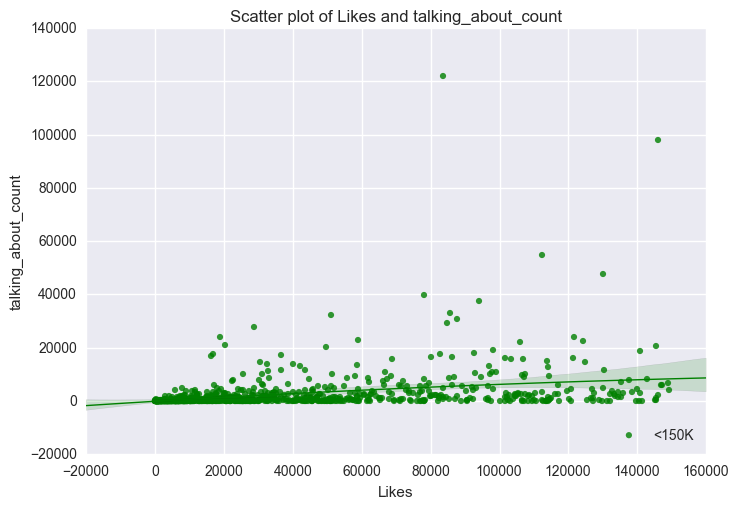

In [97]:
sns.set(color_codes=True)
scatter = pd.DataFrame()
sample = all_data[all_data['likes'] < 150000]
scatter['likes'] = sample['likes']#.apply(lambda x: x/1000)
scatter['talking_about_count'] = sample['talking_about_count']#.apply(lambda x: x/1000)
rows = random.sample(scatter.index, 1000)
scatter_10 = scatter.ix[rows]
sns.regplot('likes', 'talking_about_count', scatter_10, 
            scatter_kws={"marker": ".", "color": "green"},
            line_kws = {"linewidth": "1", "color": "green"},
            order = 2,
            label = '<150K')
plt.xlabel('Likes')
plt.ylabel('talking_about_count')
plt.legend(loc="lower right")
plt.title("Scatter plot of Likes and talking_about_count")

In [98]:
categorical_variables = ['country']

for variable in categorical_variables:
  print ("-------------------------------")
  print ("Histogram for " + variable)
  print ("-------------------------------")
  print (all_data[variable].value_counts())
  print ("")

-------------------------------
Histogram for country
-------------------------------
other             2687
United States     2517
empty             1934
India              715
Brazil             518
Philippines        421
United Kingdom     388
Egypt              353
Vietnam            318
Thailand           313
Pakistan           298
Mexico             248
Bangladesh         237
Myanmar            230
Australia          206
Israel             180
Cambodia           168
South Africa       154
Malaysia           149
Iraq               147
Italy              143
Canada             138
Turkey             115
Peru               109
Germany            108
Name: country, dtype: int64



#  Data cleaning

## Drop unnecessary columns

In [91]:
all_data.drop(['has_profile_photo', 'photo_distinct_uploaders', 'feed_is_published_count'], axis=1, inplace=True)

In [42]:
all_data[all_data['feed_is_published_count'] < 1].shape[0]

7323

## Remove Outliers

In [92]:
filtered_all_data = all_data.copy()
filtered_all_data = filtered_all_data[filtered_all_data['is_permanently_closed'] != 1].reset_index(drop=True)
filtered_all_data.drop('is_permanently_closed', axis = 1,  inplace=True)

filtered_all_data.head(5)

,has_cover_photo,id,likes,photo_avg_comments_per_photo,photo_avg_likes_per_comments,photo_avg_likes_per_photo,photo_avg_people_tagged_per_photo,photo_avg_people_tagged_per_photo_with_more_than_zero,photo_count_has_name,photo_count_has_place,...,has_website,has_location,has_description,has_general_info,has_products,name_num_of_words,photo_upload_freq,feed_update_freq,posting_freq,country
0,1,109626372391961,13311,3.25,1.50,2.50,0.00,0.00,1,2,...,1,1,1,0,0,1,3,0.00,0.16,other
1,1,834585939923334,16361,1.77,0.69,55.69,0.00,0.00,10,0,...,1,1,1,0,0,2,29,0.00,0.08,other
2,1,10150149049510092,6947,1.43,0.70,13.48,1.35,1.94,2,0,...,1,1,1,0,1,1,2,0.00,0.15,other
3,1,57843015021,227009,21.68,8.44,134.05,0.97,4.06,40,2,...,1,1,1,0,0,2,42,0.00,0.05,United Kingdom
4,1,226269077569044,288531,13.00,10.92,338.11,0.01,1.00,71,6,...,1,1,0,0,0,2,11,0.00,0.15,United States


In [51]:
normal_by_min_max = [   'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 
                        'photo_avg_likes_per_photo', 'photo_avg_people_tagged_per_photo', 
                        'photo_avg_people_tagged_per_photo_with_more_than_zero', 'photo_number_of_albums', 
                        'total_photos', 'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 
                       
                        'feed_avg_comments', 'feed_avg_likes', 'feed_avg_people_tagged_per_post', 
                        'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_avg_shares', 
                        'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_max_comments', 
                        'feed_max_likes', 'feed_max_shares', 'feed_min_comments',  'feed_min_likes', 'feed_min_shares', 
                        'feed_post_max_people_tagged', 'feed_post_max_with_tagged',
                     
                        'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_people_tagged_per_post',
                        'self_feed_avg_people_tagged_per_post_with_more_than_zero', 'self_feed_avg_shares',
                        'self_feed_avg_with_tagged_per_post', 'self_feed_avg_with_tagged_per_post_with_more_than_zero',
                        'self_feed_max_comments', 'self_feed_max_likes', 'self_feed_max_shares', 'self_feed_min_comments',
                        'self_feed_min_likes', 'self_feed_min_shares', 'self_feed_post_max_people_tagged',
                        'self_feed_post_max_with_tagged',
                        'likes']
temp2 = filtered_all_data.copy()
tot = 0
for feat in normal_by_min_max:
    temp = filtered_all_data[abs(filtered_all_data[feat] - filtered_all_data[feat].mean()) <= 3*filtered_all_data[feat].std()]
    temp2 = temp2[abs(temp2[feat] - temp2[feat].mean()) <= 3*temp2[feat].std()]
    tot += filtered_all_data.id.count() - temp.id.count()
    print "feat: %s, leaves %s samples (%s removed)" % (feat, temp.id.count(), filtered_all_data.id.count() - temp.id.count())

print tot
print "final - %s samples left" % temp2.id.count()

filtered_all_data = temp2.copy()

feat: photo_avg_comments_per_photo, leaves 12685 samples (84 removed)
feat: photo_avg_likes_per_comments, leaves 12679 samples (90 removed)
feat: photo_avg_likes_per_photo, leaves 12634 samples (135 removed)
feat: photo_avg_people_tagged_per_photo, leaves 12539 samples (230 removed)
feat: photo_avg_people_tagged_per_photo_with_more_than_zero, leaves 12474 samples (295 removed)
feat: photo_number_of_albums, leaves 12606 samples (163 removed)
feat: total_photos, leaves 12713 samples (56 removed)
feat: photo_max_like, leaves 12658 samples (111 removed)
feat: photo_max_people_tagged, leaves 12042 samples (727 removed)
feat: photo_min_like, leaves 12715 samples (54 removed)
feat: feed_avg_comments, leaves 12632 samples (137 removed)
feat: feed_avg_likes, leaves 12731 samples (38 removed)
feat: feed_avg_people_tagged_per_post, leaves 12552 samples (217 removed)
feat: feed_avg_people_tagged_per_post_with_more_than_zero, leaves 12630 samples (139 removed)
feat: feed_avg_shares, leaves 12754 sa

In [93]:
normal_by_total_count_vars = [  ['photo_number_of_cover_albums', 'photo_number_of_albums'],
                                ['photo_number_of_null_albums', 'photo_number_of_albums'],
                                ['photo_number_of_other_albums', 'photo_number_of_albums'],
                                ['photo_number_of_profile_albums', 'photo_number_of_albums'],
                                ['photo_number_of_photos_in_cover_albums', 'total_photos'],
                                ['photo_number_of_photos_in_null_albums', 'total_photos'],
                                ['photo_number_of_photos_in_other_albums', 'total_photos'],
                                ['photo_number_of_photos_in_profile_albums', 'total_photos'],
                                ['photo_count_has_name', 'total_photos'],
                                ['photo_count_has_place', 'total_photos'],
                                ['feed_count_has_place', 'feed_post_count'],
                                ['feed_count_post_updated', 'feed_post_count'],
                                ['feed_number_of_added_photos_category', 'feed_post_count'],
                                ['feed_number_of_different_months_for_post', 'feed_post_count'],
                                ['feed_number_of_null_category', 'feed_post_count'],
                                ['feed_number_of_other_categories', 'feed_post_count'],
                                ['feed_number_of_shared_story_category', 'feed_post_count'],
                                ['self_feed_count_has_place', 'self_post_count'],
                                ['self_feed_count_post_updated', 'self_post_count'],
                                ['self_feed_is_published_count', 'self_post_count'],
                                ['self_feed_number_of_added_photos_category', 'self_post_count'],
                                ['self_feed_number_of_different_months_for_post', 'self_post_count'],
                                ['self_feed_number_of_null_category', 'self_post_count'],
                                ['self_feed_number_of_other_categories', 'self_post_count'],
                                ['self_feed_number_of_shared_story_category', 'self_post_count']
                             ]

for feat in normal_by_total_count_vars: 
    filtered_all_data[feat[0]] = filtered_all_data.apply(lambda x: (x[feat[0]] / x[feat[1]]) if (x[feat[1]] != 0) else 0, axis=1)
    
# originally the api calls to facebook were supposed to get the first 150 photos/feed posts of a page.
# along the way we got a little more in some cases, so after normalization of the relevant features by this count, 
# we lower them to 150 to prevent bias..
filtered_all_data['total_photos'] = filtered_all_data['total_photos'].apply(lambda x: x if x <= 150 else 150)
filtered_all_data['feed_post_count'] = filtered_all_data['feed_post_count'].apply(lambda x: x if x <= 150 else 150)
filtered_all_data['self_post_count'] = filtered_all_data['self_post_count'].apply(lambda x: x if x <= 150 else 150)

In [56]:
# feats = [feat for feat in filtered_all_data.columns.get_values() if not feat.startswith('feed_')]
# filtered_all_data = filtered_all_data[feats]

# normal_by_min_max = [   'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 
#                         'photo_avg_likes_per_photo', 'photo_avg_people_tagged_per_photo', 
#                         'photo_avg_people_tagged_per_photo_with_more_than_zero', 'photo_number_of_albums', 
#                         'total_photos', 'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 
#                         'feed_avg_comments', 'feed_avg_likes', 'feed_avg_people_tagged_per_post', 
#                         'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_avg_shares', 
#                         'feed_avg_with_tagged_per_post', 
#                         'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_max_comments', 
#                         'feed_max_likes', 'feed_max_shares', 'feed_min_comments', 
#                         'feed_min_likes', 'feed_min_shares', 
#                         'feed_post_max_people_tagged', 'feed_post_max_with_tagged']

# filtered_all_data[normal_by_min_max] = filtered_all_data[normal_by_min_max].apply(lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0, axis=1)
# # filtered_all_data[normal_by_min_max] = preprocessing.robust_scale(filtered_all_data[normal_by_min_max])

# filtered_all_data[normal_by_min_max + [f[0] for f in normal_by_total_count_vars]].head(5)

# Models

## Utils

In [98]:
def binning(col,bin_num, labels=None):
    if labels is None:
        labels = ['BIN_'+str(i) for i in range(bin_num)]

    colBin = pd.qcut(col,bin_num,labels=labels)
    return colBin

def plot_results(x, y, tag, arg):
    plt.plot(x, y)
    plt.title(tag + " as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel(tag)
    plt.show()

def plot_cross_val(cs, cv_scores, arg):
    plt.plot(cs, cv_scores)
    plt.title("Average Precision as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel("Precision")
    ax = plt.axes()
    ax.set_xscale('log')
    plt.show()

def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()

def plotMetrics(expected,predicted):
    y_true = expected
    y_score = predicted
    #y_score = df['rawPrediction'].map(lambda x: x['values'][1])
    auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    plotRoc(fpr, tpr, auc)
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
    plotPR(precision, recall)

def plotConfusion(matrix, n):
    plt.title('Confusion Matrix Image')
    plt.imshow(np.reshape(matrix, (n, n)), interpolation='nearest', cmap="hot")
    plt.colorbar()
    plt.show()
    
def print_ds_fields(ds):
    for feat in ds.columns.get_values():
        print "%s\t%s\t%s" % (ds.columns.get_loc(feat), ds.dtypes[ds.columns.get_loc(feat)], feat)
        
def prepare_data(data_set, label_limit):
    # TODO - add shuffle
    
    if type(label_limit) is int:
        labels = pp_data['likes'].apply(lambda x: 0 if x <= 50000 else 1)
    else:
        labels = pp_data['labels'].apply(lambda x: int(x[-1]))

    train_len = int(len(data_set.id) * 0.8)

    train_set = pp_data[:train_len].copy()
    train_labels = labels[:train_len].copy()
    test_set = pp_data[train_len:].copy()
    test_labels = labels[train_len:].copy()

    train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    # set = train_set.append(test_set, ignore_index=True)
    return train_set, test_set, train_labels, test_labels

## General Preprocessing

### dummies variables 

In [95]:
# change back empty and 0 to NaN before converting to dummy variables
country_dv = pd.get_dummies(filtered_all_data['country'].apply(lambda x: x if x != 'empty' else np.nan), prefix='country')
price_dv = pd.get_dummies(filtered_all_data['price_range'].apply(lambda x: x if x > 0 else np.nan), prefix='price_range')
print "shape before dummy vars: ", filtered_all_data.shape
pp_data = pd.concat([filtered_all_data, country_dv, price_dv], axis=1)
pp_data.drop(categorical_variables, 1, inplace=True)
print "shape after dummy vars: ", pp_data.shape


shape before dummy vars:  (12769, 106)
shape after dummy vars:  (12769, 125)


### Convert likes count to bins and print bin details

In [96]:
train_len = int(len(pp_data['id']) * 0.8)
bin_num = 4
pp_data['labels'] = binning(pp_data['likes'], bin_num)

bin_data = pp_data.groupby('labels')['likes'].describe()
print bin_data
bin_names = ['BIN_0', 'BIN_1', 'BIN_2'] 
seperators = [bin_data[bin_name]['max'] for bin_name in bin_names]

labels       
BIN_0   count         3,193.00
        mean          3,587.51
        std           2,665.78
        min               0.00
        25%           1,137.00
        50%           3,121.00
        75%           5,640.00
        max           9,177.00
BIN_1   count         3,192.00
        mean         20,725.52
        std           8,187.30
        min           9,183.00
        25%          13,438.50
        50%          19,504.50
        75%          27,386.75
        max          38,087.00
BIN_2   count         3,192.00
        mean         86,217.46
        std          37,849.79
        min          38,098.00
        25%          53,146.00
        50%          76,957.00
        75%         113,797.25
        max         172,365.00
BIN_3   count         3,192.00
        mean      1,608,553.07
        std       4,217,931.21
        min         172,395.00
        25%         295,871.25
        50%         603,660.00
        75%       1,472,237.25
        max     102,762,5

### Test feature selection on Logistic Regression (sanity)

In [100]:
train_set, test_set, train_labels, test_labels = prepare_data(pp_data, 50000)

print "Logistic regression feature selection by importance:"
lr = lm.LogisticRegression(penalty='l2', C=0.01) #dual=True)
lr.fit(train_set, train_labels)
print "Train set score (before selection): ", lr.score(train_set, train_labels)
print "Test set score (before selection): ", lr.score(test_set, test_labels)

sfm = SelectFromModel(lr, prefit=True, threshold=0.0005)

selected_feats = sfm.get_support(indices=True)
print "total of %s out of %s feats left:" % (len(selected_feats), len(train_set.columns.get_values()))
for feat_idx in selected_feats:
    print "%s\t%s" % (feat_idx, train_set.columns.get_values()[feat_idx])

new_train = sfm.transform(train_set)
new_test = sfm.transform(test_set)
lr.fit(new_train, train_labels)
print "Train set score (after selection): ", lr.score(new_train, train_labels)
print "Test set score (after selection): ",  lr.score(new_test, test_labels)

 Logistic regression feature selection by importance:
Train set score (before selection):  0.806363191385
Test set score (before selection):  0.82419733751
total of 36 out of 123 feats left:
1	photo_avg_comments_per_photo
2	photo_avg_likes_per_comments
5	photo_avg_people_tagged_per_photo_with_more_than_zero
9	photo_max_people_tagged
11	photo_number_of_albums
13	photo_number_of_different_months_for_photos
21	total_photos
22	photo_number_of_days_between_first_and_last_photos
24	feed_avg_likes
28	feed_number_of_days_between_first_and_last_posts
33	feed_max_comments
46	feed_std_likes
49	feed_avg_shares
50	feed_max_shares
51	feed_min_shares
53	feed_distinct_post_writers
54	feed_post_count
55	self_feed_avg_comments
56	self_feed_avg_likes
60	self_feed_number_of_days_between_first_and_last_posts
62	self_feed_avg_with_tagged_per_post_with_more_than_zero
65	self_feed_is_published_count
76	self_feed_post_max_with_tagged
78	self_feed_std_comments
79	self_feed_std_likes
80	self_feed_sum_people_tagg

## Logistic Regression

In [ ]:
# from sklearn import (cross_validation, feature_selection, pipeline,
#                      preprocessing, linear_model, grid_search)
# lr_train_len = train_len
# lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= 50000 else 1)
# lr_ids = pp_data['id']
# lr_data_set = pp_data.copy()
# lr_data_set.drop(['likes', 'id', 'labels'], 1, inplace=True)

# folds = 5
# split = cross_validation.StratifiedKFold(lr_labels, n_folds=folds, shuffle = False, random_state = 0)

# scores = []
# for k, (train, test) in enumerate(split):

#     X_train, X_test, y_train, y_test = lr_data_set.ix[train], lr_data_set.ix[test], lr_labels.ix[train], lr_labels.ix[test]

#     top_feat = feature_selection.SelectKBest()

#     pipe = pipeline.Pipeline([('feat', top_feat),
#                               ('clf', linear_model.LogisticRegression())])

#     K = [40, 60, 80, 100]
#     C = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]
#     penalty = ['l1', 'l2']

#     param_grid = [{'feat__k': K,
#                   'clf__C': C,
#                   'clf__penalty': penalty}]

#     scoring = 'precision'

#     gs = grid_search.GridSearchCV(estimator=pipe, param_grid = param_grid, scoring = scoring)
#     gs.fit(X_train, y_train)

#     best_score = gs.best_score_
#     scores.append(best_score)

#     print "Fold: {} {} {:.4f}".format(k+1, scoring, best_score)
#     print gs.best_params_

C=1e-05: 0.891265646117
C=0.0001: 0.893284212784
C=0.001: 0.894867764263
C=0.01: 0.894296067544
C=0.1: 0.895057524492
C=1.0: 0.894960095149


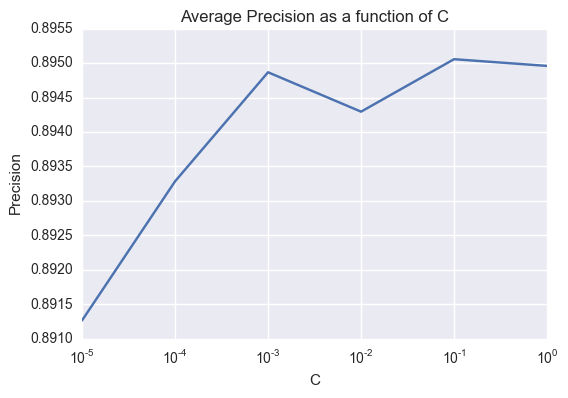

training logistic regression BIN_0
getting logistic regression predictions BIN_0
calculating logistic regression Performance on the train set: BIN_0
logistic regression train set auc: 0.903752417083
calculating logistic regression Performance on the test set: BIN_0
             precision    recall  f1-score   support

          0       0.82      0.63      0.71       508
          1       0.82      0.92      0.87       955

avg / total       0.82      0.82      0.82      1463

C=1e-05: 0.845406100004
C=0.0001: 0.851025306985
C=0.001: 0.859823075396
C=0.01: 0.863044623137
C=0.1: 0.865003281552
C=1.0: 0.86309644473


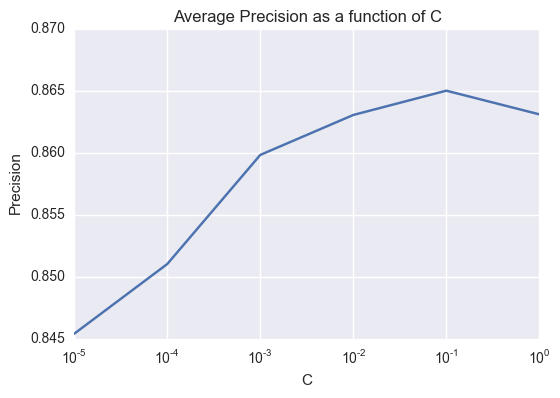

training logistic regression BIN_1
getting logistic regression predictions BIN_1
calculating logistic regression Performance on the train set: BIN_1
logistic regression train set auc: 0.869554770818
calculating logistic regression Performance on the test set: BIN_1
             precision    recall  f1-score   support

          0       0.83      0.85      0.84       860
          1       0.77      0.76      0.77       603

avg / total       0.81      0.81      0.81      1463

C=1e-05: 0.838154690803
C=0.0001: 0.846035502952
C=0.001: 0.861867845817
C=0.01: 0.877559442648
C=0.1: 0.876851631708
C=1.0: 0.873814960293


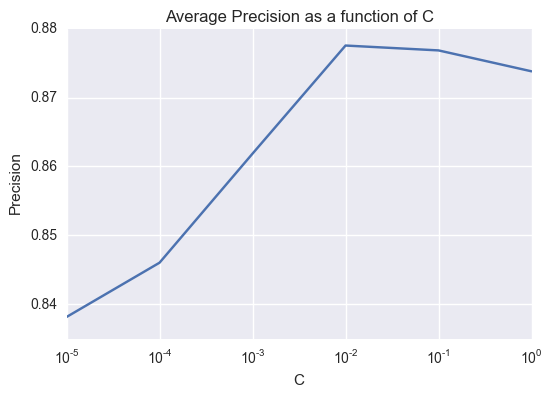

training logistic regression BIN_2
getting logistic regression predictions BIN_2
calculating logistic regression Performance on the train set: BIN_2
logistic regression train set auc: 0.878577568622
calculating logistic regression Performance on the test set: BIN_2
             precision    recall  f1-score   support

          0       0.87      0.96      0.91      1127
          1       0.80      0.53      0.64       336

avg / total       0.86      0.86      0.85      1463



In [33]:
for seperator in seperators:
    lr_train_len = train_len
    lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
    lr_ids = pp_data['id']

    lr_train_set = pp_data[:lr_train_len].copy()
    lr_test_set = pp_data[lr_train_len:].copy()

    lr_train_labels = lr_labels[:lr_train_len].copy()
    lr_test_labels = lr_labels[lr_train_len:].copy()

    lr_train_ids = lr_ids[:lr_train_len].copy()
    lr_test_ids = lr_ids[lr_train_len:].copy()

    lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_set = lr_train_set.append(lr_test_set, ignore_index=True)
    
    cv_scores = []
    space = np.logspace(-5,0, num=6)
    for c in space:
        res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='roc_auc')
        print "C=%s: %s" % (c, np.average(res))
        cv_scores.append(np.average(res))

    plot_cross_val(space, cv_scores, "C")
    lr_selceted_c = space[cv_scores.index(max(cv_scores))]
    
    print "training logistic regression", bin_names[seperators.index(seperator)]
    lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

    lr.fit(lr_train_set, lr_train_labels)
    print "getting logistic regression predictions", bin_names[seperators.index(seperator)]
    lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
    lr_predictions = lr.predict(lr_set)

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
    lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

    lr_train_predictions = lr_predictions[:lr_train_len]
    lr_test_predictions = lr_predictions[lr_train_len:]

    # attach LR predictions to the data as another feature
    pp_data['lr_prediction_%s' % bin_names[seperators.index(seperator)]] = lr_predictions.copy()
    pp_data['lr_prediction_proba_%s' % bin_names[seperators.index(seperator)]] = lr_predicted_probs.copy()

    print "calculating logistic regression Performance on the train set:", bin_names[seperators.index(seperator)]
    fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
    lr_auc = metrics.auc(fpr, tpr)
    print "logistic regression train set auc:", lr_auc
#     plotRoc(fpr, tpr, lr_auc)
    print "calculating logistic regression Performance on the test set:", bin_names[seperators.index(seperator)]
    print(metrics.classification_report(lr_test_labels, lr_test_predictions))
#     plotMetrics(lr_test_labels,lr_test_predicted_probs)


Deciding bin placements by logistic regressions binary predictions..
Got bin placements, 0 values determined by higher probability, 0 by probability sum, 8868 were definitive


ALL DATA:
[[1268  847  100    2]
 [ 341 1178  656   42]
 [ 110  695 1120  292]
 [  32  221  725 1239]]


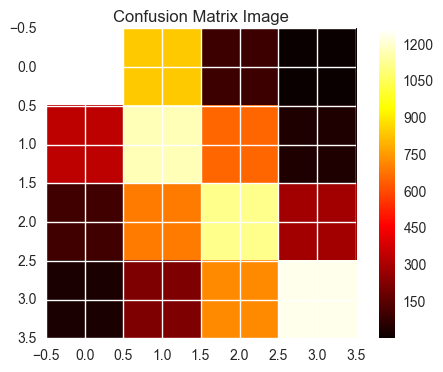

TEST SET ONLY:
[[386 213  24   0]
 [ 56 238 137  11]
 [ 13 108 152  45]
 [ 14  42 115 220]]


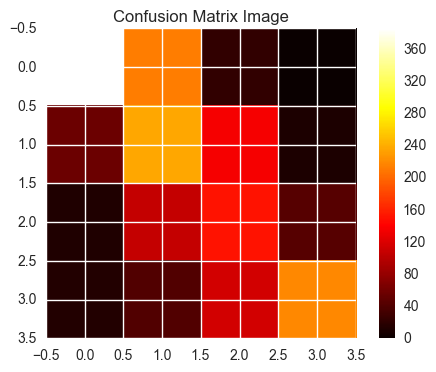

train score: 0.579903398497
train score: 0.536932619115
test score: 0.592819002579
test score: 0.561443066516


In [40]:
# unify predictions for bin classification
undef_1 = 0
undef_2 = 0

def decide_bin(row):
    global undef_1, undef_2
    preds = (row['lr_prediction_BIN_0'], row['lr_prediction_BIN_1'], row['lr_prediction_BIN_2'])
    pred_probas = (row['lr_prediction_proba_BIN_0'], row['lr_prediction_proba_BIN_1'], row['lr_prediction_proba_BIN_2'])

    if preds == (0, 0, 0):
        return 'BIN_0'
    elif preds == (1, 0, 0):
        return 'BIN_1'
    elif preds == (1, 1, 0):
        return 'BIN_2'
    elif preds == (1, 1, 1):
        return 'BIN_3'
    
    undef_1 += 1
    if preds[0] == 0 and pred_probas[0] < (1 - pred_probas[1]) and pred_probas[0] < (1 - pred_probas[2]):
        return 'BIN_0'

    if preds[2] == 1 and pred_probas[2] > (1 - pred_probas[1]) and pred_probas[2] > (1 - pred_probas[0]):
        return 'BIN_3'
    
    undef_2 += 1
    return 'BIN_%s' % int(round(sum(pred_probas)))

print "Deciding bin placements by logistic regressions binary predictions.."
bin_predictions = pp_data.apply(decide_bin, axis=1)
print "Got bin placements, %s values determined by higher probability, %s by probability sum, %s were definitive\n\n" % (undef_1, undef_2, pp_data.id.count() - undef_1 - undef_2)

print "========="
print "ALL DATA:"
print "========="
m = confusion_matrix(pp_data['labels'].values, bin_predictions.values)
print m
plotConfusion(m, 4)

print "=============="
print "TEST SET ONLY:"
print "=============="
m = confusion_matrix(pp_data['labels'][lr_train_len:].values, bin_predictions[lr_train_len:].values)
print m
plotConfusion(m, 4)

print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='macro')
print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='micro')
# print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='samples')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='macro')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='micro')
# print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='samples')

prediction_cols = ['lr_prediction_BIN_0', 'lr_prediction_BIN_1', 'lr_prediction_BIN_2', 'lr_prediction_proba_BIN_0', 'lr_prediction_proba_BIN_1', 'lr_prediction_proba_BIN_2']


4
0


IndexError: index 0 is out of bounds for axis 1 with size 0

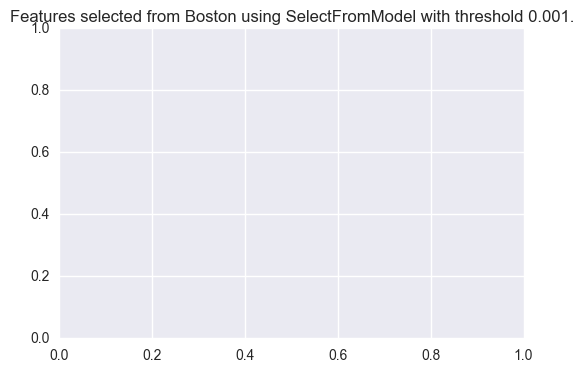

In [106]:
lr_train_len = train_len
lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= 50000 else 1)
# lr_labels = pp_data['labels'].apply(lambda x: int(x[-1]))
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_test_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_test_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_test_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)

# sfm = SelectFromModel(lm.LassoCV())
# sfm.fit(lr_train_set, lr_train_labels)
# n_features = sfm.transform(lr_train_set).shape[1]
# print n_features

# # Reset the threshold till the number of features equals two.
# # Note that the attribute can be set directly instead of repeatedly
# # fitting the metatransformer.
# while n_features > 2:
#     sfm.threshold += 0.001
#     X_transform = sfm.transform(lr_train_set)
#     n_features = X_transform.shape[1]
#     print n_features

# # Plot the selected two features from X.
# plt.title(
#     "Features selected from Boston using SelectFromModel with "
#     "threshold %0.3f." % sfm.threshold)
# feature1 = X_transform[:, 0]
# feature2 = X_transform[:, 1]
# plt.plot(feature1, feature2, 'r.')
# plt.xlabel("Feature number 1")
# plt.ylabel("Feature number 2")
# plt.ylim([np.min(feature2), np.max(feature2)])
# plt.show()

### Preprocessing

In [36]:
# lr_labelsfrom sklearn.metrics import confusion_matrixfrom sklearn.metrics import confusion_matrix = pp_data['likes']
lr_train_len = train_len
lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_test_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_test_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_test_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_set = lr_train_set.append(lr_test_set, ignore_index=True)

### Parameter optimization

C=1e-12: 0.866633983332
C=1e-11: 0.879851560951
C=1e-10: 0.883927165336
C=1e-09: 0.890033280944
C=1e-08: 0.888102944427
C=1e-07: 0.893298975005
C=1e-06: 0.902186580893
C=1e-05: 0.904886141368


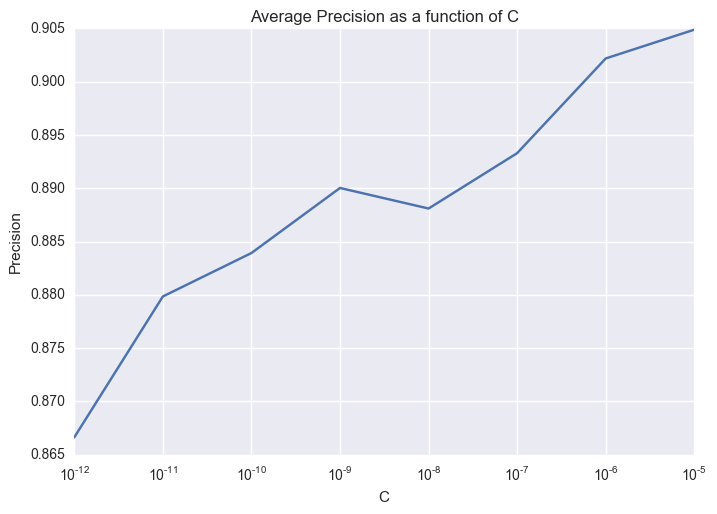

In [37]:
cv_scores = []
space = np.logspace(-10,-2, num=8)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

C=1e-10: 0.883927165336
C=2.15443469003e-10: 0.887292982014
C=4.64158883361e-10: 0.889880287287
C=1e-09: 0.890033280944
C=2.15443469003e-09: 0.889221849537
C=4.64158883361e-09: 0.888324973356
C=1e-08: 0.888102944265


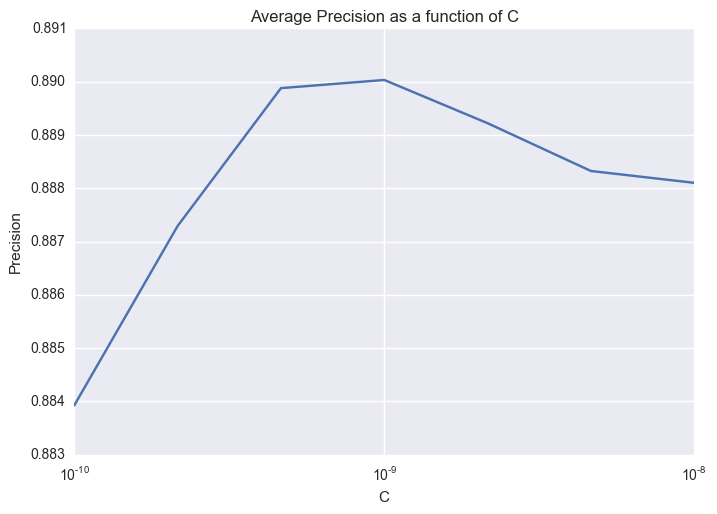

In [38]:
cv_scores = []
space = np.logspace(-10,-8, num=7)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

### LR running 

training logistic regression
getting logistic regression predictions
calculating logistic regression Performance on the train set:
logistic regression train set auc: 0.865343621882


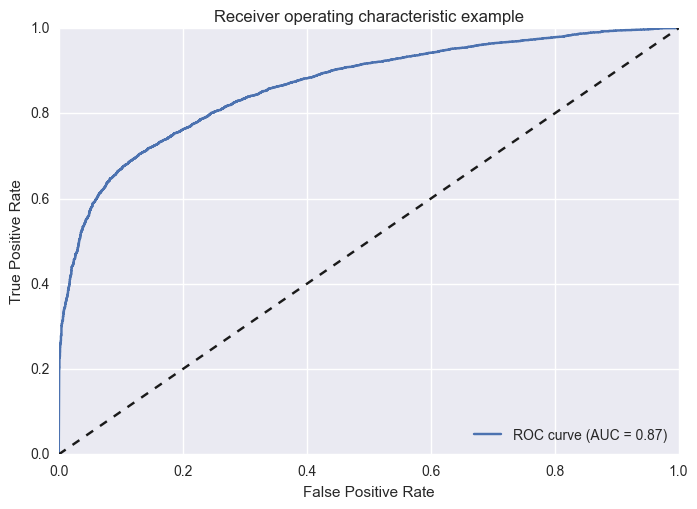

calculating logistic regression Performance on the test set:
             precision    recall  f1-score   support

          0       0.78      0.92      0.84      1506
          1       0.84      0.63      0.72      1059

avg / total       0.81      0.80      0.79      2565



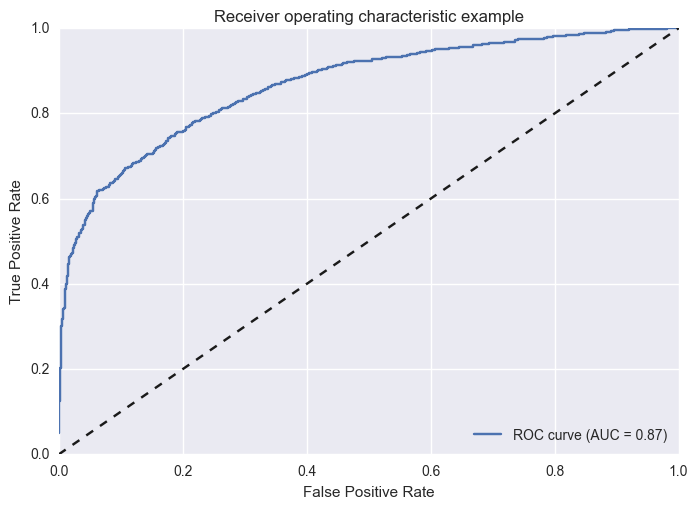

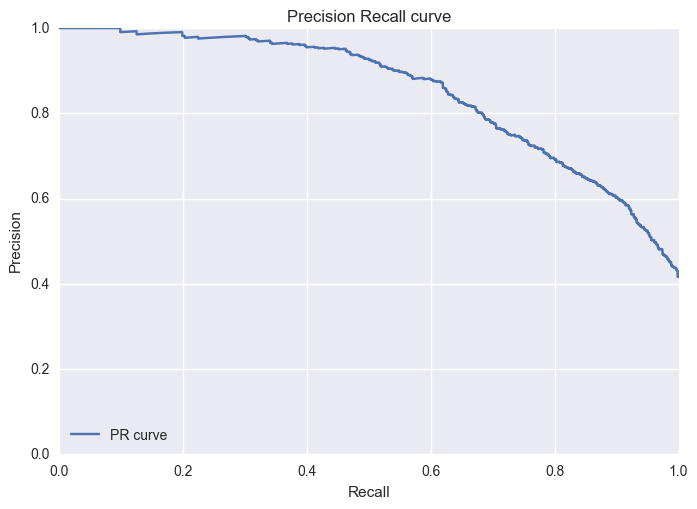

In [39]:
print "training logistic regression"
lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

lr.fit(lr_train_set, lr_train_labels)
print "getting logistic regression predictions"
lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
lr_predictions = lr.predict(lr_set)

lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

lr_train_predictions = lr_predictions[:lr_train_len]
lr_test_predictions = lr_predictions[lr_train_len:]

# attach LR predictions to the data as another feature
pp_data['lr_prediction'] = lr_predictions.copy()

print "calculating logistic regression Performance on the train set:"
fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
lr_auc = metrics.auc(fpr, tpr)
print "logistic regression train set auc:", lr_auc
plotRoc(fpr, tpr, lr_auc)
print "calculating logistic regression Performance on the test set:"
print(metrics.classification_report(lr_test_labels, lr_test_predictions))
plotMetrics(lr_test_labels,lr_test_predicted_probs)

# pected = test_class.values
# oh_test_data= oh_test.drop('class',axis=1)
# predicted = logreg.predict(oh_test_data)
# predicted_probs = logreg.predict_proba(oh_test_data)

#add LR score as a new feature
# train_set['logistic_regression_prediction'] = lr_train_predictions
# test_set['logistic_regression_prediction'] = lr_test_predictions

## SVM

### Preprocessing

In [40]:
svm_pp_data = pp_data.copy()
svm_train_len = train_len
svm_test_len = int(len(pp_data['id'])) - train_len
# svm_pp_data.drop(categorical_variables, 1, inplace=True)

svm_labels = svm_pp_data['likes'].apply(lambda x: 0 if x < seperator else 1)
svm_ids = svm_pp_data['id']

svm_train_set = svm_pp_data[:svm_train_len].copy()
svm_test_set = svm_pp_data[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_labels = svm_labels[:svm_train_len].copy()
svm_test_labels = svm_labels[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_ids = svm_ids[:svm_train_len].copy()
svm_test_ids = svm_ids[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
svm_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
svm_set = svm_train_set.append(svm_test_set, ignore_index=True)

### Parameter optimization 

C=1e-05: 0.527208519529
C=0.0001: 0.530358758403
C=0.001: 0.532842925863
C=0.01: 0.534132758145
C=0.1: 0.535914847971
C=1: 0.543450087451
C=10: 0.543853211037
C=100: 0.543853211037


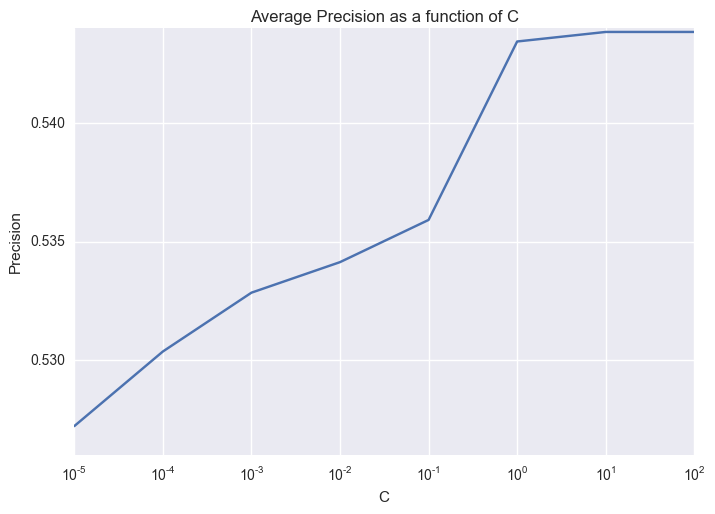

In [42]:
cv_scores = []
cs = []
for c in range(-5,3):#-2,2):
    res = cross_val_score(svm.SVC(C=10**c), svm_train_set, svm_train_labels, cv=3, scoring='roc_auc')
    print "C=%s: %s" % (10**c, np.average(res))
    cs.append(10**c)
    cv_scores.append(np.average(res))
    
plot_cross_val(cs, cv_scores, "C")
svm_selceted_c = cv_scores[cv_scores.index(max(cv_scores))]

### SVM run

In [518]:
# svm_selceted_c = 16.681005372
# svm_selceted_gamma = 0.0316227766017

svm_model = svm.SVC(probability=True, C=svm_selceted_c)#, gamma=svm_selceted_gamma)
svm_model.fit(pp_train_set, pp_train_labels)
svm_train_prediction = svm_model.predict_proba(pp_train_set)
svm_test_prediction = svm_model.predict_proba(pp_test_set)

fpr, tpr, thresholds = metrics.roc_curve(pp_train_labels, svm_train_prediction[:,1])
svm_train_auc = metrics.auc(fpr, tpr)
print "svm train set auc:", svm_train_auc

plotRoc(fpr, tpr, svm_train_auc)

(6689, 191)

## Random Forest

### Preprocessing

In [122]:
rf_train_len = train_len
rf_labels = pp_data['labels']
rf_ids = pp_data['id']

rf_train_set = pp_data[:rf_train_len].copy()
rf_test_set = pp_data[rf_train_len:].copy()


rf_train_ids = rf_ids[:rf_train_len].copy()
rf_test_ids = rf_ids[rf_train_len:].copy()

rf_train_labels = rf_labels[:rf_train_len].copy()
rf_test_labels = rf_labels[rf_train_len:].copy()

rf_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
rf_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)



### Parameter optimization

Feature ranking - Top 10:
1. feature 59 (talking_about_count)
   score: 0.083431
2. feature 26 (feed_avg_likes)
   score: 0.051956
3. feature 37 (feed_max_likes)
   score: 0.046413
4. feature 30 (feed_number_of_days_between_first_and_last_posts)
   score: 0.045365
5. feature 49 (feed_std_likes)
   score: 0.045333
6. feature 10 (photo_max_like)
   score: 0.043458
7. feature 24 (photo_number_of_days_between_first_and_last_photos)
   score: 0.041132
8. feature 23 (total_photos)
   score: 0.040242
9. feature 4 (photo_avg_likes_per_photo)
   score: 0.036338
10. feature 25 (feed_avg_comments)
   score: 0.032298


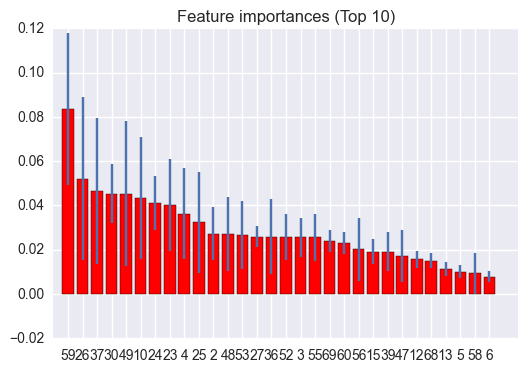

In [123]:
forest = RandomForestClassifier(n_estimators=250, max_depth=15)
forest.fit(rf_train_set.values, rf_train_labels.values)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking - Top 10:")
for f in range(10):
    print("%d. feature %d (%s)\n   score: %f" % (f + 1, indices[f], list(rf_train_set)[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plot_idxs = indices[:30]
plt.figure()
plt.title("Feature importances (Top 10)")
plt.bar(range(30), importances[plot_idxs],
       color="r", yerr=std[plot_idxs], align="center")
plt.xticks(range(30), plot_idxs)
plt.xlim([-1, 31])
plt.show()

In [124]:
importances_thresholds = [0, 0.01] #[0, 0.01, 0.02, 0.03, 0.04]
max_depths = [15, None] #[10, 20, 30, None]
min_samples_leaf = [1] #[1, 3, 5]

filtered_by_thresholds = []
for t in importances_thresholds:
    columns = []
    for f in range(rf_train_set.shape[1]):
        if importances[indices[f]] >= t:
            columns.append(list(rf_train_set)[indices[f]])
    filtered_by_thresholds.append(columns)

params = []
score_summary = []
print "(threshold, depth, min_samples) -> average precision score"
for i in range(len(filtered_by_thresholds)):
    for d in max_depths:
        for l in min_samples_leaf:
            cols = filtered_by_thresholds[i]
            forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=d, min_samples_leaf=l)
            forest.fit(rf_train_set, rf_train_labels)
            temp_predictions = forest.predict(rf_test_set)
            res = metrics.precision_score(rf_test_labels, temp_predictions, average='macro')
            score_summary.append(res)
            params.append((importances_thresholds[i], d, l))
            print "%s -> %s" % (params[-1], score_summary[-1])
    
max_idx = np.argmax(score_summary)
best_threshold = params[max_idx][0]
best_max_depth = params[max_idx][1]
best_min_leaf = params[max_idx][2]

# Print best hyper parameters
print "RF best parameters:"
print "max_depth = ", best_max_depth
print "importance_threshold = ", best_threshold
print "min_samples_leaf = ", best_min_leaf

(threshold, depth, min_samples) -> average precision score
(0, 15, 1) -> 0.619424994133
(0, None, 1) -> 0.609534026303
(0.01, 15, 1) -> 0.619424994133
(0.01, None, 1) -> 0.609534026303
RF best parameters:
max_depth =  15
importance_threshold =  0
min_samples_leaf =  1


### RF running

Random Forest test precision: 0.61939680647
[[506 112   7   0]
 [119 214 105   9]
 [ 22  90 149  63]
 [ 18  26  72 263]]


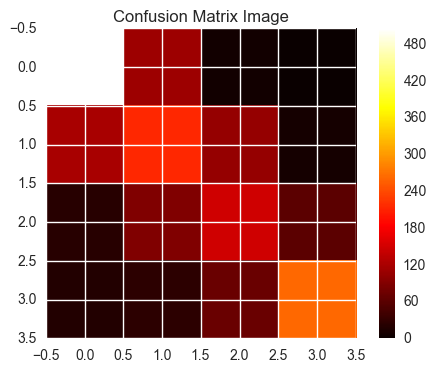

In [125]:
fc = filtered_by_thresholds[importances_thresholds.index(best_threshold)]
forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_test_predicted_probs = forest.predict_proba(rf_test_set[fc])
rf_test_predictions = forest.predict(rf_test_set[fc])
res = metrics.precision_score(rf_test_labels, rf_test_predictions, average='macro')
print "Random Forest test precision:", res

cm_rf_labels = rf_test_labels.apply(lambda x: x[-1])
cm_rf_predictions = [a[-1] for a in rf_test_predictions.tolist()]
m = confusion_matrix(cm_rf_labels.values, cm_rf_predictions)
print m
plotConfusion(m, bin_num)

## LR - numrical predictions - DELETE ME

In [61]:
lr2_pp_data = all_data.copy()
lr2_pp_data.drop(categorical_variables, 1, inplace=True)
lr2_pp_data = lr2_pp_data[lr2_pp_data['likes'] > 50000]
lr2_pp_data = lr2_pp_data.sample(frac=1)

lr2_train_len = 1000
lr2_test_len = 100
lr2_labels = pp_data['likes']
lr2_ids = pp_data['id']

lr2_train_set = pp_data[:lr2_train_len].copy()
lr2_test_set = pp_data[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_labels = lr2_labels[:lr2_train_len].copy()
lr2_test_labels = lr2_labels[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_ids = lr2_ids[:lr2_train_len].copy()
lr2_test_ids = lr2_ids[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_set.drop(['likes', 'id'], 1, inplace=True)
lr2_test_set.drop(['likes', 'id'], 1, inplace=True)
lr2_set = lr2_train_set.append(lr2_test_set, ignore_index=True)

In [62]:
lr2 = lm.LogisticRegression(penalty='l1', C=10**(-3))  #penalty='l2' #dual=True) #lr_selceted_c)

print "training logistic regression"
lr2.fit(lr2_train_set, lr2_train_labels)

print "getting logistic regression predictions"
lr2_predictions = lr2.predict(lr2_set)

print "calculating logistic regression Performance on the test set:"
lr2.score(lr2_test_set, lr2_test_labels, sample_weight=None)

# lr2_train_predicted_probs = lr2_predicted_probs[:lr_train_len]
# lr2_test_predicted_probs = lr2_predicted_probs[lr_train_len:]

# lr2_train_predictions = lr2_predictions[:lr_train_len]
# lr2_test_predictions = lr2_predictions[lr_train_len:]

training logistic regression
getting logistic regression predictions
calculating logistic regression Performance on the test set:


0.0

In [63]:
predicted = lr2_predictions[lr2_train_len:]
actual = lr2_test_labels.values
ratio = np.divide(predicted * 1.0, actual)

print 'median: ', np.median(ratio)
print 'mean: ', ratio.mean()
print 'std: ', ratio.std()
print 'min: ', ratio.min()
print 'max: ', ratio.max()


median:  1.3370815948
mean:  1.61211175502
std:  1.40803569521
min:  0.0
max:  7.02683595441


<function matplotlib.pyplot.show>

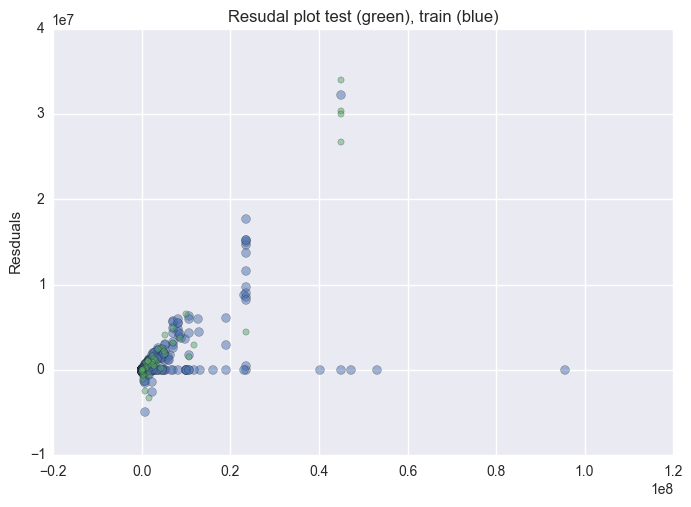

In [65]:
#TODO: add scatter plot predicted vs actual

plt.scatter(lr2_predictions[:lr2_train_len], lr2_predictions[:lr2_train_len] -  lr2_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(lr2_predictions[lr2_train_len:], lr2_predictions[lr2_train_len:] -  lr2_test_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=-10, xmax=50)
plt.title('Resudal plot test (green), train (blue)')
plt.ylabel('Resduals')
plt.show